In this script I'll build the ANN for a regresion

In [1]:
# Importing Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics 
import keras_tuner as kt
import time
import h5py

In [2]:
insurance_data = pd.read_csv("in\insurance.csv")
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Categorical to integrer
insurance_data['region'].unique()
insurance_data['region'].replace(['southwest', 'southeast', 'northwest', 'northeast'], 
          [0, 1, 2, 3], inplace=True)

In [4]:
insurance_data['smoker'].unique()
insurance_data['smoker'].replace(['no', "yes"], 
            [0, 1], inplace=True)

In [5]:
insurance_data['sex'].unique()
insurance_data['sex'].replace(['female', 'male'], 
            [0, 1], inplace=True)

In [6]:
insurance_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,0,16884.92400
1,18,1,33.770,1,0,1,1725.55230
2,28,1,33.000,3,0,1,4449.46200
3,33,1,22.705,0,0,2,21984.47061
4,32,1,28.880,0,0,2,3866.85520


In [7]:
# Spliting data into features and labels
X = insurance_data.iloc[:,:6].values
y = insurance_data["charges"].values

In [8]:
# Spliting the dataset into train, test and val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Split Train between train and validate / 268 is the 20% of the balanced dataset
X_val = X_train[:268]
partial_X_train = X_train[268:]

y_val = y_train[:268]
partial_y_train = y_train[268:]

# Length
print('# Train;', partial_X_train.shape[0])
print('# Val;', X_val.shape[0])
print('# Test;', X_test.shape[0])

# Train; 802
# Val; 268
# Test; 268


In [9]:
# Standarization of the data
std = StandardScaler().fit(partial_X_train)
X_ptrain_std = std.transform(partial_X_train)
X_test_std = std.transform(X_test)
X_val_std = std.transform(X_val)

In [10]:
X_ptrain_std.shape

(802, 6)

In [11]:
X_train.shape

(1070, 6)

In [12]:
# Building the ANN v 1.0
Model_1 = Sequential()
Model_1.add(Dense(1024, activation='relu', input_shape=(6,)))
Model_1.add(Dense(512, activation='relu'))
Model_1.add(Dense(256, activation='relu'))
Model_1.add(Dense(128, activation='relu'))
Model_1.add(Dense(64, activation='relu'))
Model_1.add(Dense(32, activation='relu'))
Model_1.add(Dense(1))

Model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              7168      
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dense_6 (Dense)             (None, 1)                 3

In [13]:
Model_1.compile(optimizer='rmsprop', loss='mae', metrics=["mae"])

In [14]:
Hist_1 = Model_1.fit(X_ptrain_std,
                   partial_y_train,
                   epochs=100,
                   batch_size=512,
                   validation_data=(X_val_std, y_val))

Epoch 1/100
2/2 [==============================] - 3s 629ms/step - loss: 13279.5215 - mae: 13279.5215 - val_loss: 12962.9023 - val_mae: 12962.9023
Epoch 2/100
2/2 [==============================] - 0s 74ms/step - loss: 13273.6387 - mae: 13273.6387 - val_loss: 12936.7500 - val_mae: 12936.7500
Epoch 3/100
2/2 [==============================] - 0s 64ms/step - loss: 13236.7646 - mae: 13236.7646 - val_loss: 12833.6689 - val_mae: 12833.6689
Epoch 4/100
2/2 [==============================] - 0s 70ms/step - loss: 13106.3965 - mae: 13106.3965 - val_loss: 12555.2031 - val_mae: 12555.2031
Epoch 5/100
2/2 [==============================] - 0s 72ms/step - loss: 12776.9160 - mae: 12776.9160 - val_loss: 11958.8486 - val_mae: 11958.8486
Epoch 6/100
2/2 [==============================] - 0s 82ms/step - loss: 12097.3076 - mae: 12097.3076 - val_loss: 10926.7529 - val_mae: 10926.7529
Epoch 7/100
2/2 [==============================] - 0s 80ms/step - loss: 11012.5986 - mae: 11012.5986 - val_loss: 9716.1211 

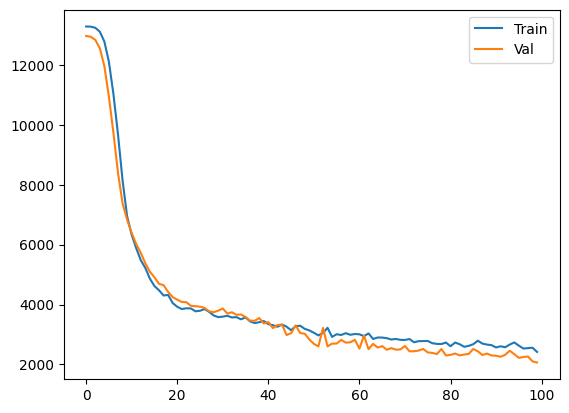

In [15]:
# Checking the overfitting
plt.plot(Hist_1.history['mae'], label='Train')
plt.plot(Hist_1.history['val_mae'], label='Val')
plt.legend()
plt.show()

In [16]:
# Evaluating the final result
y_train_predict_1 = Model_1.predict(X_ptrain_std)
y_test_predict_1 = Model_1.predict(X_test_std)

# The R2 metric
r2_train_1 = metrics.r2_score(partial_y_train, y_train_predict_1)
r2_test_1 = metrics.r2_score(y_test, y_test_predict_1)

# Print the results
print("R2 score for training is: ", r2_train_1)
print("R2 score for testing is: ", r2_test_1)

9/9 [==============================] - 0s 4ms/step
R2 score for training is:  0.7994690344483542
R2 score for testing is:  0.8729048994345301


Here I got the first Neural Network to predict the insurances charges. In this case there's a great error. It could be for the outlier that I found in the EDA part and because the target variables was not standardized  as well.

The idea is to build other models to compare what is the best one.

In [17]:
# Building the ANN v 2.0
# Despite of there's no a remarkable underfitting in the model 1. Here I'll add regularazer and some layer to see their impact in the result
Model_2 = Sequential()
Model_2.add(Dense(1024, activation='relu', input_shape=(6,), kernel_regularizer=regularizers.l1(1e-4)))
Model_2.add(Dense(512, activation='relu'))
Model_2.add(Dropout(0.2))
Model_2.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
Model_2.add(Dense(128, activation='relu'))
Model_2.add(Dropout(0.2))
Model_2.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l1(1e-4)))
Model_2.add(Dense(32, activation='relu'))
Model_2.add(Dense(1))

Model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1024)              7168      
                                                                 
 dense_8 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 64)               

In [18]:
Model_2.compile(optimizer='rmsprop', loss='mae', metrics=["mae"])

Hist_2 = Model_2.fit(X_ptrain_std,
                   partial_y_train,
                   epochs=100,
                   batch_size=512,
                   validation_data=(X_val_std, y_val))

Epoch 1/100
2/2 [==============================] - 3s 455ms/step - loss: 13280.3408 - mae: 13279.6709 - val_loss: 12965.6152 - val_mae: 12964.9697
Epoch 2/100
2/2 [==============================] - 0s 81ms/step - loss: 13278.1650 - mae: 13277.5225 - val_loss: 12955.5479 - val_mae: 12954.9170
Epoch 3/100
2/2 [==============================] - 0s 76ms/step - loss: 13263.4062 - mae: 13262.7764 - val_loss: 12909.6689 - val_mae: 12909.0459
Epoch 4/100
2/2 [==============================] - 0s 66ms/step - loss: 13201.5586 - mae: 13200.9365 - val_loss: 12756.0166 - val_mae: 12755.3975
Epoch 5/100
2/2 [==============================] - 0s 63ms/step - loss: 13009.2744 - mae: 13008.6562 - val_loss: 12363.0459 - val_mae: 12362.4258
Epoch 6/100
2/2 [==============================] - 0s 72ms/step - loss: 12544.0771 - mae: 12543.4580 - val_loss: 11540.1338 - val_mae: 11539.5107
Epoch 7/100
2/2 [==============================] - 0s 65ms/step - loss: 11642.4775 - mae: 11641.8545 - val_loss: 10348.0117

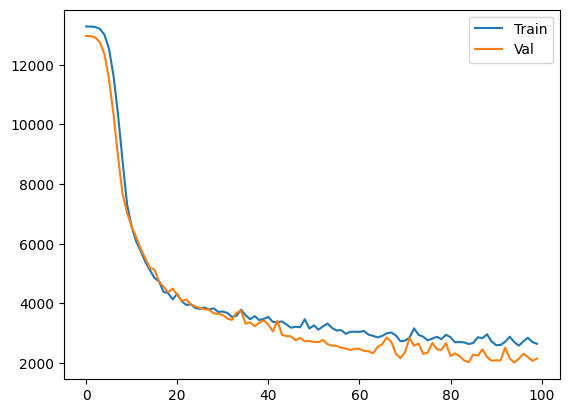

In [19]:
# Checking the overfitting
plt.plot(Hist_2.history['mae'], label='Train')
plt.plot(Hist_2.history['val_mae'], label='Val')
plt.legend()
plt.show()

In [20]:
# Evaluating the final result
y_train_predict_2 = Model_2.predict(X_ptrain_std)
y_test_predict_2 = Model_2.predict(X_test_std)

# The R2 metric
r2_train_2 = metrics.r2_score(partial_y_train, y_train_predict_2)
r2_test_2 = metrics.r2_score(y_test, y_test_predict_2)

# Print the results
print("R2 score for training is: ", r2_train_2)
print("R2 score for testing is: ", r2_test_2)

9/9 [==============================] - 0s 6ms/step
R2 score for training is:  0.8153879263996037
R2 score for testing is:  0.8842035210295113


The result between the model 1 (without regularization) and the model 2 (with) does not change much. 
Highlining, there's no a remarkable overtiffit as it is written above.

Next a Early Stopping will be applied to the model 1 (the simple one) to avoid over-training.

In [21]:
callback_early = EarlyStopping(monitor = "val_mae", patience=25, mode = "auto")

Hist_3 = Model_1.fit(X_ptrain_std,
                   partial_y_train,
                   epochs=500, # more number of epochs due to EarlyStopping
                   batch_size=512,
                   callbacks = [callback_early],
                   validation_data=(X_val_std, y_val))

Epoch 1/500
2/2 [==============================] - 0s 127ms/step - loss: 2412.9236 - mae: 2412.9236 - val_loss: 2018.3711 - val_mae: 2018.3711
Epoch 2/500
2/2 [==============================] - 0s 66ms/step - loss: 2430.0078 - mae: 2430.0078 - val_loss: 2129.2046 - val_mae: 2129.2046
Epoch 3/500
2/2 [==============================] - 0s 71ms/step - loss: 2543.7559 - mae: 2543.7559 - val_loss: 2351.5190 - val_mae: 2351.5190
Epoch 4/500
2/2 [==============================] - 0s 74ms/step - loss: 2645.1047 - mae: 2645.1047 - val_loss: 2332.2981 - val_mae: 2332.2981
Epoch 5/500
2/2 [==============================] - 0s 70ms/step - loss: 2634.6992 - mae: 2634.6992 - val_loss: 2322.9573 - val_mae: 2322.9573
Epoch 6/500
2/2 [==============================] - 0s 67ms/step - loss: 2587.8606 - mae: 2587.8606 - val_loss: 2243.1448 - val_mae: 2243.1448
Epoch 7/500
2/2 [==============================] - 0s 65ms/step - loss: 2554.8003 - mae: 2554.8003 - val_loss: 2140.8423 - val_mae: 2140.8423
Epoch

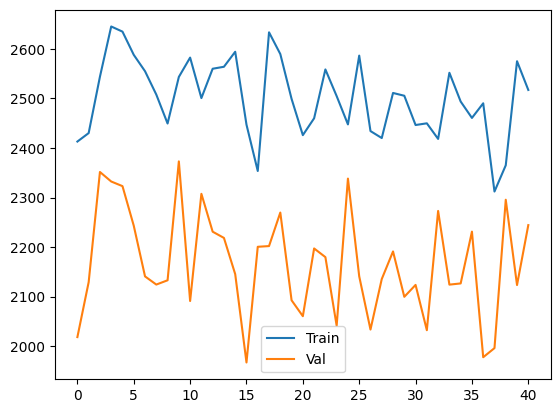

In [22]:
# Checking the overfitting
# The best Epoch applying a Early Stopping call back is before the epoch 93
plt.plot(Hist_3.history['mae'], label='Train')
plt.plot(Hist_3.history['val_mae'], label='Val')
plt.legend()
plt.show()

In [23]:
# Evaluating the final result
y_train_predict_3 = Model_1.predict(X_ptrain_std)
y_test_predict_3 = Model_1.predict(X_test_std)

# The R2 metric
r2_train_3 = metrics.r2_score(partial_y_train, y_train_predict_3)
r2_test_3 = metrics.r2_score(y_test, y_test_predict_3)

# Print the results
print("R2 score for training is: ", r2_train_3)
print("R2 score for testing is: ", r2_test_3)

9/9 [==============================] - 0s 5ms/step
R2 score for training is:  0.788331539177356
R2 score for testing is:  0.8599189250850582


The last got the best accuracy. Early stopping helps to regularize the Neural Network.
Now, Let's compare this model with a simple linear regression.

In [37]:
# The linear regression
regressor = LinearRegression().fit(X_ptrain_std,partial_y_train)
y_train_linear =  regressor.predict(X_ptrain_std)
y_test_linear =  regressor.predict(X_test_std)

# R2 score
r2_train_4 = metrics.r2_score(partial_y_train, y_train_linear)
r2_test_4 = metrics.r2_score(y_test, y_test_linear)

# Print the results
print("R2 score for training is: ", r2_train_4)
print("R2 score for testing is: ", r2_test_4)

R2 score for training is:  0.7218470836941686
R2 score for testing is:  0.7983490052336844


Comparing the result for the simple linear regression and the Neural Network. It is possible to realize that the ANN has a better accuracy which shows the potential for the deep learning. Although, Deep Learning is not always the best way.

Now Let's try Keras_tuner to improve the best ANN

In [25]:
def model_builder(hp):

  # Hyper-Parameters
  neurons_hp = hp.Int(name = 'start_neurons', min_value = 32, max_value = 1024, step = 64)
  optimizer_hp = hp.Choice('optimizer', values = ['RMSprop', 'Adam', 'SGD'])
  activation_hp = hp.Choice(name = 'activation', values = ['elu', 'selu', 'relu'])

  # Model Structure
  Model = Sequential()
  Model.add(Dense(units=neurons_hp, activation=activation_hp, input_shape=(6,)))
  Model.add(Dense(units=neurons_hp, activation=activation_hp))  
  Model.add(Dense(units=neurons_hp, activation=activation_hp))
  Model.add(Dense(units=neurons_hp, activation=activation_hp))
  Model.add(Dense(units=neurons_hp, activation=activation_hp))
  Model.add(Dense(units=neurons_hp, activation=activation_hp))
  Model.add(Dense(1))

  # Compile it
  Model.compile(optimizer=optimizer_hp, loss='mae', metrics=["mae"])

  return Model

In [26]:
tuner = kt.Hyperband( # There are 2 more methods
    model_builder,
    objective = "val_mae",
    max_epochs = 100,
    factor = 3, 
    directory = "out/",
    project_name = "regressor-tunner" 
)

In [29]:
# The Auto Keras part
tuner.search(X_ptrain_std, partial_y_train, epochs=100, validation_data=(X_val_std, y_val))

Trial 182 Complete [00h 00m 12s]
val_mae: 4306.59814453125

Best val_mae So Far: 3220.832763671875
Total elapsed time: 00h 27m 00s
INFO:tensorflow:Oracle triggered exit


In [33]:
best_hps = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models()[0]

In [35]:
# Saved my model
best_model.save("out\ANN_regressor.h5")

To conclude, Deep Learning is a useful tool to get better results (not always). And for this specific case the neural network was able to get a good model to predict the insurance charge based on some customers data, even better than a traditional regression linear model.